# Natural neighbour interpolation

[Simon Dobson](mailto:simon.dobsoN@st-andrews.ac.uk)<br>
School of Computer Science, University of St Andrews, Scotland UK 

The natural nearest neighbour interpolation method used in developing the CEH-GEAR dataset is a complicated algorithm. In this notebook we conduct a step-by-step development and testing process for the algorithm as described.

In [1]:
from itertools import product
import numpy
from geopandas import GeoDataFrame

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.geometry import shape, Point, Polygon
from shapely.ops import cascaded_union

## Simple Voronoi cells

We will start with the simplest possible arrangement: a square. 

In [2]:
df_frame = GeoDataFrame([Point(0.0, 0.0),
                         Point(0.0, 1.0),
                         Point(1.0, 1.0),
                         Point(1.0, 0.0)], columns=['geometry'])
df_frame

,geometry
0,POINT (0.00000 0.00000)
1,POINT (0.00000 1.00000)
2,POINT (1.00000 1.00000)
3,POINT (1.00000 0.00000)


In this square, we place 4 sample points.

In [3]:
df_points = GeoDataFrame([Point(0.25, 0.25),
                          Point(0.75, 0.25),
                          Point(0.75, 0.75),
                          Point(0.25, 0.75)], columns=['geometry'])
df_points

,geometry
0,POINT (0.25000 0.25000)
1,POINT (0.75000 0.25000)
2,POINT (0.75000 0.75000)
3,POINT (0.25000 0.75000)


The boundary can be turned into a shape simply by taking its co-ordinate points.

In [4]:
df_boundary = GeoDataFrame([Polygon(list(df_frame.geometry))], columns=['geometry'])

boundary_shape = cascaded_union(df_boundary.geometry)
coords = points_to_coords(df_points.geometry)

Using this data. we can now create Voronoi cells around the sample points, which will (unsurprisingly) form squares within the square.  

In [5]:
# create a table of Voronoi cells and their centres
voronoi_cells, voronoi_centres = voronoi_regions_from_coords(coords, boundary_shape)
df_voronoi = GeoDataFrame(columns=['centre', 'geometry'])
for i in voronoi_cells.keys():
    df_voronoi.loc[len(df_voronoi.index)] = {'centre': df_points.iloc[voronoi_centres[i][0]].geometry,
                                             'geometry': voronoi_cells[i]}

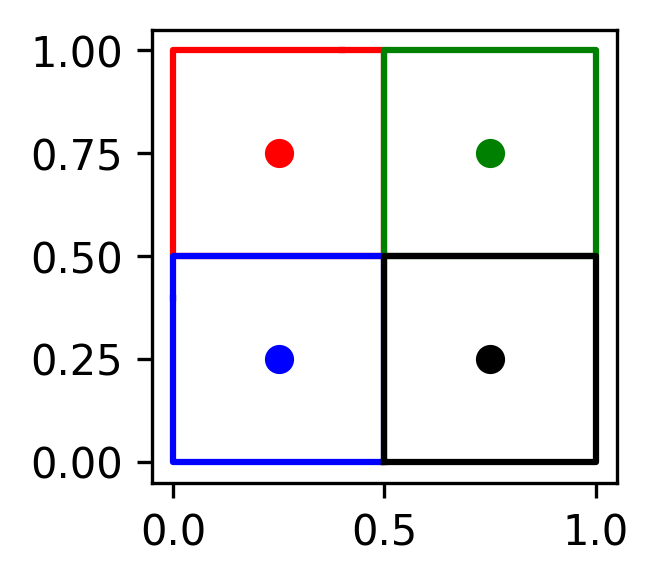

In [26]:
fig = plt.figure(figsize=(2, 2))

colours = ['r', 'g', 'b', 'k']

for i in range(len(df_voronoi)):
    v = df_voronoi.loc[i]
    [(x, y)] = list(v.centre.coords)
    plt.scatter([x], [y], c=colours[i])

    xs, ys = v.geometry.exterior.xy
    plt.plot(xs, ys, c=colours[i])
    
_ = plt.show()

## Sampling and interpolation

We now need to add samples to the points. We do this by creating a new DataFrame with some specific rainfalls at the four sample points. To start with, we'll make everywhere zero apart from one point.

In [7]:
df_rainfall = df_points.copy()
df_rainfall['rainfall'] = [50, 0, 0, 0]
df_rainfall

,geometry,rainfall
0,POINT (0.25000 0.25000),50
1,POINT (0.75000 0.25000),0
2,POINT (0.75000 0.75000),0
3,POINT (0.25000 0.75000),0


This data forms the input to the natural nearest neighbour algorithm. This takes an initial boundary shape and set of sample points, and constructs the Voronoi diagram for them. It then creates "synthetic" sample points at a range of points across the space, and constructs a new Voronoi diagram that includes a synthetic point -- as trhough a sample were taken there. It sets the value at this synthetic point as the weighted sums of the actual samples, weighted by the degree to which the Voronoi cell of trhe synthetic sample points overlaps with those of the underlying "real" cells.

In [174]:
def natural_nearest_neighbour(df_points, boundary_shape, xs, ys):
    '''Interpolate samples given by the df_points `DataFrame`
    at positions given by co-ordinates from xs and ys.
    
    The sample points should be supplied in a `GeoDataFrame` having
    columns `geometry` containing the sample points and `rainfall`
    holding the observation at that point. All the samples should
    lie within the boundary_shape.
    
    The returned `DataFrame` will have columns `geometry` for the
    interpolated points, `x` and `y` for the indices of the observation
    along the two axes, and `rainfall` for the interpolated rainfall.
    
    :param df_points: the samples
    :param boundary_shape: the boundary surrounding the samples
    :param xs: list of x co-ordinates to interpolate at
    :param ys: list of y co-ordinates to interpolate at
    :returns: a dataframe'''
    
    # check that all the sample points lie within the boundary
    if not df_complicated.geometry.within(boundary_shape).all():
        raise ValueError('At least one point lies on or outside the boundary')
    
    # construct the real Voronoi cells around the sample points
    coords = points_to_coords(df_points.geometry)
    voronoi_cells, voronoi_centres = voronoi_regions_from_coords(coords, boundary_shape)
    df_voronoi = GeoDataFrame({'centre': [df_points.iloc[voronoi_centres[i][0]].geometry for i in voronoi_cells.keys()],
                               'geometry': voronoi_cells.values()})
    
    # add the neighbourhoods of each cell, the indices of the cells
    # that they touch (including the index of the cell itself)
    # TODO compute the boundary and coordinates here too 
    neighbourhood = []
    for i in range(len(df_voronoi.index)):
        cell = df_voronoi.iloc[i]
        neighbourhood.append(list(df_voronoi[df_voronoi.geometry.touches(cell.geometry)].index) + [i])
    df_voronoi['neighbourhood'] = neighbourhood

    # construct the interpolation points
    df_interpoints = GeoDataFrame({'x': [i for l in [[j] * len(ys) for j in range(len(xs))] for i in l],
                                   'y': list(range(len(list(ys)))) * len(xs),
                                   'geometry': [Point(x, y) for (x, y) in product(xs, ys)]})

    try:
        # perform the interpolation
        real_cell = None                 # the real cell the sample point lies in
        df_real_neighbourhood = None     # the real neighbourhood of this real cell, including the cell itself
        real_coords = None               # co-ordinates of the neighhbourhood sample points
        real_boundary_shape = None       # the boundary of the neighbourhood
        interpolated_rainfall = []
        for p in df_interpoints.geometry:
            # check whether this point lies in a differenr real cell to
            # the last point, which will necessitate a change of neighbourhood
            if real_cell is None or not real_cell.intersects(p):
                # yes, re-compute the neighbourhood of Voronoi cells,
                # the only ones that the cell around this sample point
                # can intersect and so the only computation we need to do
                c = df_voronoi[df_voronoi.geometry.intersects(p)]
                real_cell = c.iloc[0].geometry
                df_real_neighbourhood = df_voronoi.loc[df_voronoi.loc[c.index[0]].neighbourhood]
                real_coords = points_to_coords(df_real_neighbourhood.centre)
                real_boundary_shape = cascaded_union(df_real_neighbourhood.geometry)
                
            # re-compute the Voronoi cells
            synthetic_coords = numpy.append(real_coords, points_to_coords([p]), axis=0)
            synthetic_voronoi_cells, synthetic_voronoi_centres = voronoi_regions_from_coords(synthetic_coords, real_boundary_shape)
    
            # get the synthetic cell
            i = [i for i in synthetic_voronoi_centres.keys() if len(synthetic_coords) - 1 in synthetic_voronoi_centres[i]][0]
            synthetic_cell = synthetic_voronoi_cells[i]
            
            # compute the weighted value
            synthetic_cell_area = synthetic_cell.area
            synthetic_rainfall = 0
            total_area = 0
            for _, r in df_real_neighbourhood.iterrows():
                area = r.geometry.intersection(synthetic_cell).area
                total_area += area
                if area > 0.0:
                    obs = df_points[df_points.geometry == r.centre].iloc[0].rainfall
                    synthetic_rainfall += (area / synthetic_cell_area) * obs
            
            # store synthetic rainfall
            interpolated_rainfall.append(synthetic_rainfall)
        
        # return the interpolated data
        df_interpoints['rainfall'] = interpolated_rainfall
        return df_interpoints
    finally:
        # drop the synthetic point, leaving the original samples untouched
        #df_points.drop(index=m, inplace=True)
        pass

We test the algorithm by sampling from the boundary in a regular grid with 20 samples on a side. 

In [32]:
df = natural_nearest_neighbour(df_rainfall, boundary_shape, numpy.linspace(0.0, 1.0, num=20), numpy.linspace(0.0, 1.0, num=20))

This results in a GeoDataFrame with the interpolated results in it, which we can turn into an array for easier processing. The array is formed using the sample points as axes.

In [115]:
def interpolation_to_image(df_interpolation):
    '''Return an array of interpolated data.
    
    :param df_interpolation: the interpolated values
    :returns: an array of values'''
    
    # create the array
    im = numpy.zeros((len(df_interpolation.x.unique()), len(df_interpolation.y.unique())))
    
    # populate the array
    for _, r in df_interpolation[['x', 'y', 'rainfall']].iterrows():
        im[int(r.x), int(r.y)] = r.rainfall
        
    return im

Plotting this array results in an interpolated sample with a single "high point" and smoothly decreasing values as we move away from the sampled point (other samples being zero).

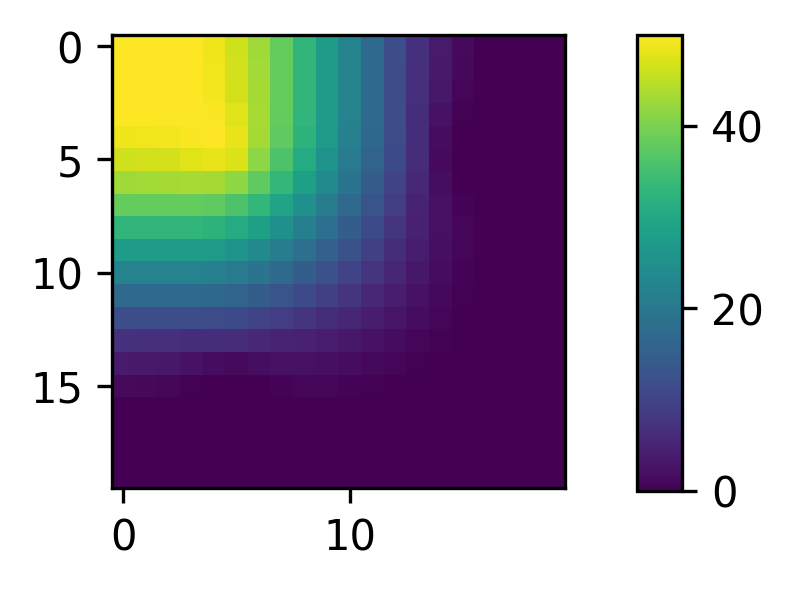

In [23]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(interpolation_to_image(df), norm=Normalize(min(df.rainfall), max(df.rainfall)))
cax = plt.axes([1.01, 0.12, 0.075, 0.76])
_ = plt.colorbar(cax=cax)

Let's try with another sample set, this time symmetrical across the diagonal.

In [24]:
df_rainfall = df_points.copy()
df_rainfall['rainfall'] = [50, 0, 50, 0]
df_rainfall

,geometry,rainfall
0,POINT (0.25000 0.25000),50
1,POINT (0.75000 0.25000),0
2,POINT (0.75000 0.75000),50
3,POINT (0.25000 0.75000),0


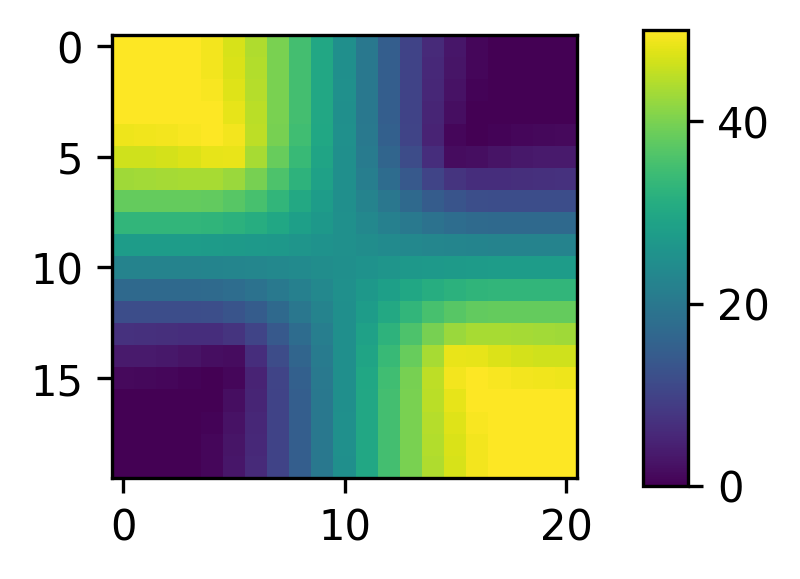

In [33]:
df = natural_nearest_neighbour(df_rainfall, boundary_shape, numpy.linspace(0.0, 1.0, num=20), numpy.linspace(0.0, 1.0, num=20))

fig = plt.figure(figsize=(2, 2))
plt.imshow(interpolation_to_image(df), norm=Normalize(min(df.rainfall), max(df.rainfall)))
cax = plt.axes([1.01, 0.12, 0.075, 0.76])
_ = plt.colorbar(cax=cax)

## A more complex shape

One optimisation we added to the algorithm is to keep track of the neighbourhoods of each Voronoi cell to reducve the number of intersection calculations needed. This doesn't actually help in the simple case -- in fact it slows things down, since every cell is always in the neighbourhood of every interpolation point -- so we need a more complicated arrangement to test it.

In [169]:
complicated = [Point((numpy.random.random() * 0.90) + 0.05,
                     (numpy.random.random() * 0.90) + 0.05) for _ in range(20)]
samples = [0] * len(complicated)
samples[1] = 30
samples[int(len(complicated) / 2)] = 50
df_complicated = GeoDataFrame({'geometry': complicated,
                               'rainfall': samples})

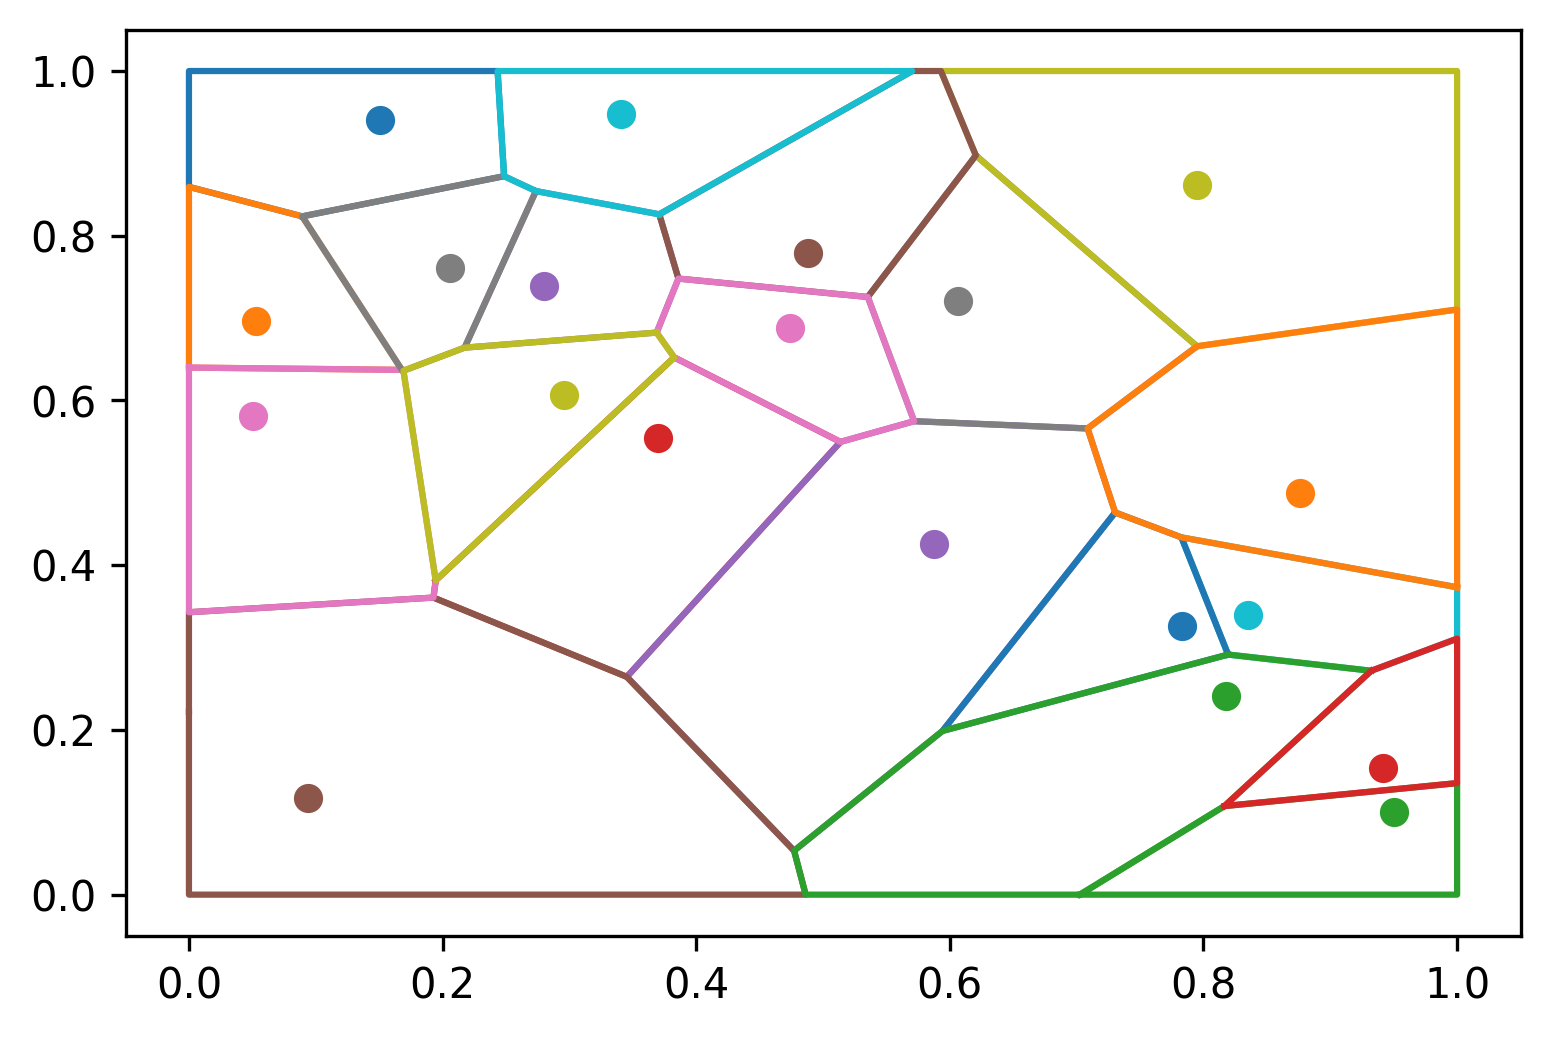

In [170]:
coords = points_to_coords(df_complicated.geometry)
voronoi_cells, voronoi_centres = voronoi_regions_from_coords(coords, boundary_shape)
df_voronoi = GeoDataFrame(columns=['centre', 'geometry'])
for i in voronoi_cells.keys():
    df_voronoi.loc[len(df_voronoi.index)] = {'centre': df_complicated.iloc[voronoi_centres[i][0]].geometry,
                                             'geometry': voronoi_cells[i]}
neighbourhood = []
for i in range(len(df_voronoi.index)):
    cell = df_voronoi.iloc[i]
    neighbourhood.append(list(df_voronoi[df_voronoi.geometry.touches(cell.geometry)].index) + [i])
df_voronoi['neighbourhood'] = neighbourhood

for i in range(len(df_voronoi)):
    v = df_voronoi.loc[i]
    [(x, y)] = list(v.centre.coords)
    plt.scatter([x], [y])

    xs, ys = v.geometry.exterior.xy
    plt.plot(xs, ys)

_ = plt.show()

In [175]:
df_complicated_rainfall = natural_nearest_neighbour(df_complicated, boundary_shape, numpy.linspace(0.0, 1.0, num=20), numpy.linspace(0.0, 1.0, num=20))

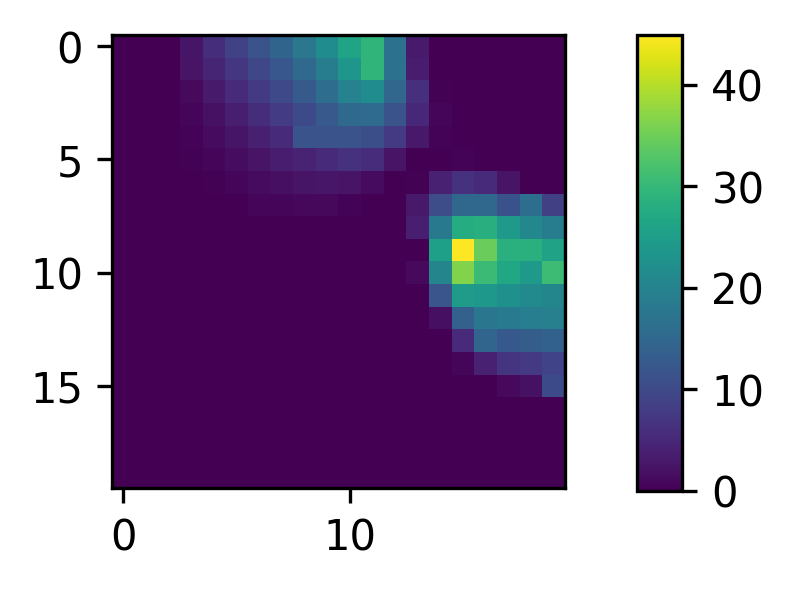

In [176]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(interpolation_to_image(df_complicated_rainfall), norm=Normalize(min(df_complicated_rainfall.rainfall), max(df_complicated_rainfall.rainfall)))
cax = plt.axes([1.01, 0.12, 0.075, 0.76])
_ = plt.colorbar(cax=cax)